# **AP157 Module C Lab Assignment**

## Module C2: Monte Carlo Methods

_Instructions_: Answer each part of the assignment as completely as you can. Discuss **all** your code and results as clearly and concisely as possible.

_Scoring Criteria_: 50% - *correctness of code*; 50% - *discussion of the code and results*. Maximum score is **100 points**.

_Credits_: This lab assignment is based on work by Dr. Reyes in collaboration with Gene Belinario and Dr. Reginald Bernardo.

### Student Information

_Full Name (Last Name, First Name)_: \
_Student No._:\
_Section_:

### Submission Information

_Date and Time Submitted (most recent upload)_:

**HONOR PLEDGE** I affirm that I have upheld the highest principles of honesty and integrity in my academic work and that this lab assignment is my own work.

**Sign here with your full name:**

### Grading Information (c/o Instructor)

TOTAL SCORE: **[]**/100

Score breakdown:
* Part 1 - []/20
* Part 2 - []/20
* Part 3 - []/30
* Part 4 - []/30

_Date and Time Scored (MM/DD/YYYY HH:MM AM/PM):_

In this lab assignment, you will generate constraints on cosmological parameters, the Hubble parameter H_0 and matter density Omega_m,0, from (synthetic) Hubble diagram data points from gravitational-wave (GW) sirens observed from 3 GW observatories: LIGO, LISA, and Einstein Telescope (ET).

The datasets are in the Google Drive "Datasets" Folder under "AP157_moduleC2" subfolder: https://drive.google.com/drive/folders/1UnK1AggxdsjtG3PoOcyXfpahBcWjOBzj?usp=drive_link.

Read in the 3 datasets from the CSV files: LIGO.csv, LISA.csv, ET.csv. The columns are redshift (z), luminosity distance (dL), and error in the luminosity distance (err). The distances are in units of Gpc (giga-parsecs).

Load the data into variable names: zLIGO, dLLIGO, errLIGO, zLISA, dLLISA, errLISA, and zET, dLET, and errET, respectively. Note that these variable names will be used in later parts of the code, so you have to use these names for compatibility.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

c:\Users\Ian\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [21]:
ligo_data = pd.read_csv('LIGO.csv')
lisa_data = pd.read_csv('LISA.csv')
et_data = pd.read_csv('ET.csv')

zLIGO, dlLIGO, errLIGO = ligo_data['zLIGO'], ligo_data['dlLIGO'], ligo_data['errLIGO']
zLISA, dlLISA, errLISA = lisa_data['zLISA'], lisa_data['dlLISA'], lisa_data['errLISA']
zET, dlET, errET = et_data['zET'], et_data['dlET'], et_data['errET']

In [19]:
ligo_data

,zLIGO,dlLIGO,errLIGO
0,0.033270,0.101250,0.026146
1,0.106210,0.698621,0.137968
2,0.073820,0.338016,0.067550
3,0.047333,0.206075,0.034506
4,0.113966,0.401371,0.159718
...,...,...,...
95,0.140751,0.607664,0.249926
96,0.170735,1.064420,0.380081
97,0.073560,0.278404,0.067117
98,0.113640,0.456064,0.158766


By the end of the lab assignment, you will generate constraints on the cosmological parameters H_0 and omega_m,0 for 3 samples: LIGO only, LIGO+LISA, and LIGO+LISA+ET (combined). You will generate a corner plot to visualize these constraints similar to the figure here: https://drive.google.com/file/d/18H7GPlox4ijS9qFbk1rHo-NW5N_Nsfer/view?usp=drive_link

#### PART 1 - Generate Hubble Diagram *(20 points)*

Make a Hubble diagram plot-- with luminosity distance (d_L) in the vertical axis and redshift (z) in the horizontal axis. Show the errors in d_L as error bars.

Plot GW sirens from the 3 observatories in the same plot and include a legend. Briefly describe the difference between the samples from the 3 observatories.

<AxesSubplot:xlabel='zLIGO', ylabel='dlLIGO'>

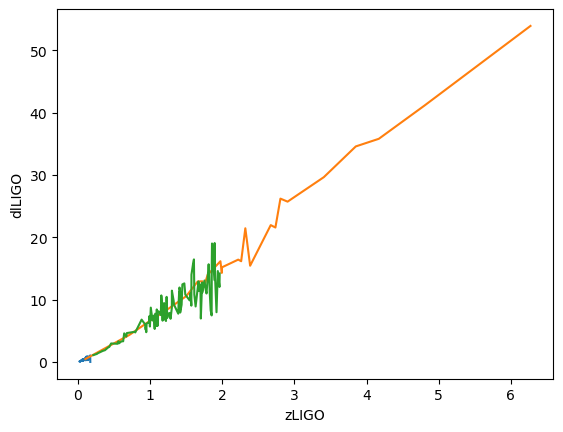

In [4]:
sns.lineplot(data=ligo_data, x='zLIGO', y='dlLIGO')
sns.lineplot(data=lisa_data, x='zLISA', y='dlLISA')
sns.lineplot(data=et_data, x='zET', y='dlET')

In [18]:
ligo_data['zLIGO']

0     0.033270
1     0.106210
2     0.073820
3     0.047333
4     0.113966
        ...   
95    0.140751
96    0.170735
97    0.073560
98    0.113640
99    0.030374
Name: zLIGO, Length: 100, dtype: float64

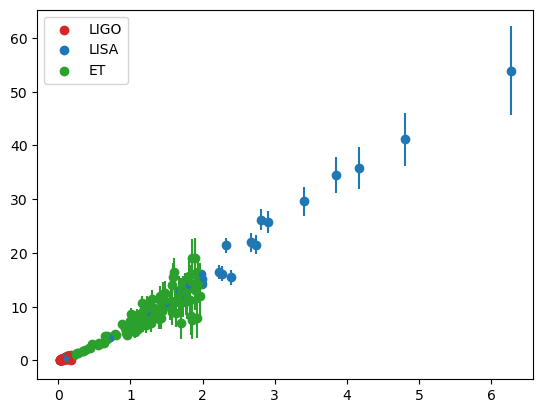

In [24]:
plt.scatter(zLIGO, dlLIGO, label='LIGO', color='tab:red')
plt.errorbar(zLIGO, dlLIGO, yerr=errLIGO, fmt='.', color='tab:red')
plt.scatter(zLISA, dlLISA, label='LISA', color='tab:blue')
plt.errorbar(zLISA, dlLISA, yerr=errLISA, fmt='.', color='tab:blue')
plt.scatter(zET, dlET, label='ET', color='tab:green')
plt.errorbar(zET, dlET, yerr=errET, fmt='.', color='tab:green')
plt.legend()
plt.show()

#### PART 2 - Define likelihood functions *(20 points)*

In this analysis, we will assume the cosmological model to be flat LambdaCDM universe. This is given by the `FlatLambdaCDM' model from the astropy.cosmology package. In particular, we use the model for the luminosity distance as a function of redshift, which is encoded in the luminosity_distance function.

Below, define the chi-square and likelihood function to be used for the LIGO only and the LIGO+LISA dataset. You are asked to define the analogous functions for the LIGO+LISA+ET dataset. Note that the likelihood for the combined dataset is simply the sum of the likelihoods for the individual datasets.




In [7]:
from astropy.cosmology import FlatLambdaCDM

In [25]:
def chi2LIGO_lcdm(H0, Om0):
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0, Tcmb0=2.725)      # define cosmological model
    model = np.array(cosmo.luminosity_distance(zLIGO)/1000) # converted from Gpc to Mpc units
    dev = (model - np.array(dlLIGO))/np.array(errLIGO)      # deviations between model and data
    chi2 = sum(dev**2)
    return chi2

def llikeLIGO_lcdm(H0, Om0):
    if (H0 < 0) or (Om0 < 0):
        return -np.inf                        # return inf if outside priors
    else:
        return -0.5*chi2LIGO_lcdm(H0, Om0)

# LIGO + LISA
def chi2LISA_lcdm(H0, Om0):
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0, Tcmb0=2.725)
    model = np.array(cosmo.luminosity_distance(zLISA)/1000)
    dev = (model - np.array(dlLISA))/np.array(errLISA)
    chi2 = sum(dev**2)
    return chi2

def llikeLIGOLISA_lcdm(H0, Om0):
    if (H0 < 0) or (Om0 < 0):
        return -np.inf
    else:
        return -0.5*(chi2LIGO_lcdm(H0, Om0) + chi2LISA_lcdm(H0, Om0))

# LIGO + LISA + ET
def chi2ET_lcdm(H0, Om0):
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0, Tcmb0=2.725)
    model = np.array(cosmo.luminosity_distance(zET)/1000)
    dev = (model - np.array(dlET))/np.array(errET)
    chi2 = sum(dev**2)
    return chi2

def llikeLIGOLISAET_lcdm(H0, Om0):
    if (H0 < 0) or (Om0 < 0):
        return -np.inf
    else:
        return -0.5*(chi2LIGO_lcdm(H0, Om0) + chi2LISA_lcdm(H0, Om0) + chi2ET_lcdm(H0, Om0))

#### PART 3 - Perform MCMC runs *(30 points)*

Use the emcee library to set up and perform MCMC runs for the 3 samples: LIGO only, LIGO+LISA, and LIGO+LISA+ET combined.

You can use number of walkers (nwalkers) of 6 and number of iterations (niter) of 5,000 and number of burn-in samples (nburn) of 100.


In [27]:
import emcee as mc

pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = mc.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 5000, progress=True);

#### PART 4 - Generate corner plot to visualize the constraints *(30 points)*

Overlay the results for the 3 samples for easy comparison. Your plot should resemble the figure here: https://drive.google.com/file/d/18H7GPlox4ijS9qFbk1rHo-NW5N_Nsfer/view?usp=drive_link

Briefly describe the difference between the constraints obtained from the different samples.